# Synthetic Confounding Plot

We create the follow plot for Appendix I:
- x-axis strength of confounding
- y-axis estimated ATE 

In [1]:
from causal_eval.sampling import *

import seaborn as sns
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2 

In [2]:
# random seed for the sampling methods same throughout
rng = np.random.default_rng(10)

### Synthetic DGP Setting #1 

In [3]:
data, rct_ace = synthetic_dgp(setting=1, num_samples=100000)

Sanity check
RCT ACE unadjusted:  2.4809951502961516
RCT ACE adjusting for C parametric backdoor:  2.4864917936261794


In [4]:
def weights_for_rejection(data, confound_strength): 
    T = data["T"]
    pT = np.mean(T) * np.ones(len(data))
    pT[data["T"] == 0] = 1 - pT[data["T"] == 0]
    p_TC =  expit(-1 + confound_strength * data["C"]) #Line that is changed given argument
    p_TC[data["T"] == 0] = 1 - p_TC[data["T"] == 0]
    weights = p_TC / pT
    return weights, p_TC, pT

I'm choosing the confounding strength grid so that $0.05 < P(T|C) < 0.95$ to ensure overalp. 

In [5]:
CONFOUNDING_STRENGTH_GRID = np.arange(-1, 4, 0.5)

for x in CONFOUNDING_STRENGTH_GRID: 
    print(expit(-1 + x))

0.11920292202211755
0.18242552380635635
0.2689414213699951
0.3775406687981454
0.5
0.6224593312018546
0.7310585786300049
0.8175744761936437
0.8807970779778823
0.9241418199787566


Now, gather the data for many random seeds. 

In [6]:
NUM_RANDOM_SEEDS = 1000

x_axis_confound_strength = []
y_axis_ace = []

for seed in range(NUM_RANDOM_SEEDS): 
    rng = np.random.default_rng(seed)
    for confound_strength in CONFOUNDING_STRENGTH_GRID: 
        weights, p_TC, pT = weights_for_rejection(data, confound_strength)
        M = np.max(p_TC) / np.min(pT)
        data_resampled = rejection_sampler(data, weights, rng, M=M)
        if check_invalid_sample(data_resampled): continue
        sample_ace = parametric_backdoor(data_resampled, "Y", "T", ["C", "T*C"])
        
        x_axis_confound_strength.append(confound_strength)
        y_axis_ace.append(sample_ace)

Invalid sample, T*C==T for all units


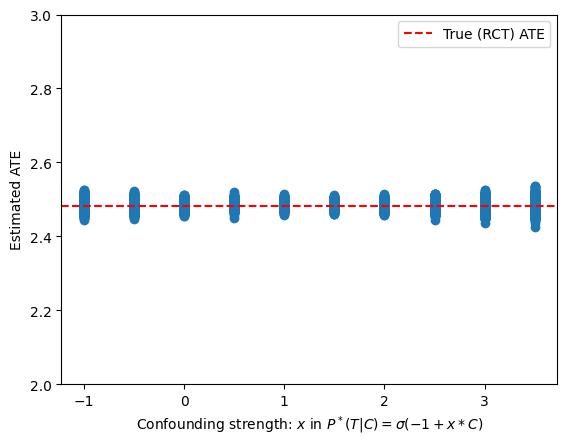

In [7]:
plt.scatter(x_axis_confound_strength, y_axis_ace)
plt.xlabel("Confounding strength: $x$ in $P^*(T|C) = \sigma(-1+x*C)$")
plt.ylim(2, 3)
plt.axhline(y=rct_ace, color='r', linestyle='--', label="True (RCT) ATE")
plt.legend()
plt.ylabel("Estimated ATE");